# LSTM Composer

Simple Stacked LSTM

Some part of the code were taken as is (helper functions), or adapted (train and trainIters) from the pytorch tutorial "NLP From Scratch: Translation with a Sequence to Sequence Network and Attention" by Sean Robertson.

link: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [13]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt

Mount Disk

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# mount
path_to_project = "/content/drive/MyDrive/Colab Notebooks/NLP6010/Project6010" #@param string
%cd $path_to_project

/content/drive/MyDrive/Colab Notebooks/NLP6010/Project6010


In [23]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/NLP6010/Project6010'

Prepare the training data

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_sentences(datapath):
    # Get a list of tokenized sentences from a corpus
    data = []
    f = open(datapath, "r")
    for line in f:
        sent = [word for word in line.split(' ') if word is not '\n']
        data.append(sent)
    f.close()

    return data

def build_vocab():
    # Build a list with the modified vocabulary of "Music with Expressivity..."
    # size: 267+1PAD = 268
    vocab = []

    #0: PAD
    vocab.append("<PAD>")

    for note in range(128):
        vocab.append("NOTE_ON<{}>".format(note))
        vocab.append("NOTE_OFF<{}>".format(note))

    for tick in [120, 240, 360, 480, 600, 720, 840, 960]:
        vocab.append("TICKSHIFT<{}>".format(tick))

    for token in ["<START>", "<END>", "SILENCE"]:
        vocab.append(token)

    return vocab

def build_training_batch(datapath):
    """
    Create a one hot encoding for all the input data
    """
    corpus = get_sentences(datapath)
    vocab = build_vocab()

    #List of indices
    vector_seqs = [[vocab.index(tok) for tok in seq] for seq in corpus]

    seq_lengths = torch.LongTensor(list(map(len, vector_seqs)))

    #Pad the sequences: pad idx==0
    seq_tensor = torch.autograd.Variable(torch.zeros((len(vector_seqs), seq_lengths.max()))).long()

    for idx, (seq, seqlen) in enumerate(zip(vector_seqs, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    #Shape: (B x S)

    """
    #Embed the seqs
    embed = nn.Embedding(len(vocab), embed_dim)
    embed_seq_tensor = embed(seq_tensor) #Shape: (B x S x Emb)

    #Pack seq
    packed_input = pack_padded_sequence(embed_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)
    # packed_input (PackedSequence is NamedTuple with 2 attributes: data and batch_sizes
    """
    #seq_tensor: padded sequences (B x MAX_SEQ_LEN)
    #seq_lengths: lens of each seq
    #vocab: list of tokens

    return seq_tensor, seq_lengths, vocab


Model

In [25]:

class LSTMcomposer(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_stack, vocab, embed_dim):
        super(LSTMcomposer, self).__init__()
        self.in_size = in_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.n_stack = n_stack
        self.out_size = out_size #correspond to 1-hot vector of an event

        self.embed = nn.Embedding(len(vocab), embed_dim)
        self.lstm = nn.LSTM(in_size, hidden_size, n_stack, batch_first=True)
        self.out = nn.Linear(hidden_size, out_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, seq, seq_len):
        #seq_tensor: S_MAX
        #seq_lengths: 1
        #input: (B, S, F)
        #h_0: (B, n_stack, hidden_size) init state for each element in batch
        #c_0: (B, n_stack, hidden_size) init cell state for each element in batch
        # out, (h_n, c_n) = self.lstm(input, (h_0, c_0))

        output = []

        h_t = self.initHidden()
        c_t = self.initHidden()

        embed_seq = self.embed(seq)  # Shape: (S x Emb)
        embed_seq = embed_seq.to(device)

        for ti in range(seq_len):
            out, (h_t, c_t) = self.lstm(embed_seq[ti].unsqueeze(0).unsqueeze(0), (h_t, c_t))
            out = self.out(out)
            score = self.softmax(out)
            output.append(score)

        output = torch.stack(output).to(device)

        return output

    def initHidden(self):
        return torch.zeros(1, self.n_stack, self.hidden_size, device=device)
    
    def generate(self, start_token, vocab, MAX_LEN=728):
      song = []

      with torch.no_grad():
              h_t = self.initHidden()
              c_t = self.initHidden()

      curr_idx = start_token.item()
      
      embed_seq = self.embed(start_token)  # Shape: (1 x Emb)
      embed_seq = embed_seq.to(device)

      for ti in range(MAX_LEN):
          out, (h_t, c_t) = self.lstm(embed_seq.unsqueeze(0), (h_t, c_t))
          out = self.out(out)
          score = self.softmax(out)

          sorted_ids = torch.argsort(score)
          # print(sorted_ids.squeeze().cpu().numpy().shape)
          for idx in sorted_ids.squeeze().cpu().numpy():
            if idx == curr_idx:
              pass
            else:
              song.append(vocab[idx])
              curr_idx = idx
              break
          
          nxt_token = torch.LongTensor([idx])
          nxt_token = nxt_token.to(device)
          nxt_embed = self.embed(nxt_token)

          embed_seq = nxt_embed

          if song[-1] == '<END>':
            break

      return song


In [26]:
#Train for 1 epoch
def train(lstm, lstm_optim, criterion, seq_tensor, seq_lengths):

  S_MAX = seq_tensor.shape[1]
  batch_size = seq_tensor.shape[0]
  loss = 0

  lstm_optim.zero_grad()

  #todo: Change to batch size FOR REAL
  for ei in range(batch_size):
    seq = seq_tensor[ei]
    seq_len = seq_lengths[ei]
    logits = lstm(seq, seq_len)
    logits = logits.squeeze().squeeze()

    #Build target: end token have pad as their target
    target = np.zeros(seq_len)
    labels = seq.cpu().numpy()
    target[:(seq_len-1)] = labels[1:seq_len]
    target = torch.LongTensor(target)
    target = target.to(device)

    loss = loss + criterion(logits, target)

  loss.backward()
  lstm_optim.step()

  return loss.item()/ S_MAX

In [27]:
#Helper fcts

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # # this locator puts ticks at regular intervals
    # loc = ticker.MultipleLocator(base=0.2)
    # ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def trainItersLSTM(lstm, seq_tensor, seq_lengths, n_iter, print_every=1000, plot_every=100, save_every=2, lr=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 #reset every print_every
    plot_loss_total = 0 #reset every plot_every

    lstm_optim = torch.optim.Adam(lstm.parameters(), lr)

    criterion = nn.NLLLoss()

    for iter in range(1,n_iter+1):
        loss = train(lstm, lstm_optim, criterion, seq_tensor, seq_lengths)

        print_loss_total = print_loss_total + loss
        plot_loss_total = plot_loss_total + loss

        if iter % save_every == 0:
            torch.save({'epoch': iter,
                        'model_state_dict': lstm.state_dict(),
                        'optimizer_state_dict': lstm_optim.state_dict(),
                        'loss': loss
                        }, 'lstm.pth')
            print("~Saved checkpoint")

        if iter % print_every ==0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iter),
                                         iter, iter / n_iter * 100,
                                         print_loss_avg))

        if iter % plot_every ==0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0



    #Save models
    torch.save(lstm.state_dict(), "lstm.pt")

    showPlot(plot_losses)

    return 0

~Saved checkpoint
4m 24s (- 215m 48s) (2 2%) 1.5369
~Saved checkpoint
8m 48s (- 211m 23s) (4 4%) 1.3444
~Saved checkpoint
13m 11s (- 206m 41s) (6 6%) 1.1861
~Saved checkpoint
17m 33s (- 202m 0s) (8 8%) 0.9869
~Saved checkpoint
21m 57s (- 197m 35s) (10 10%) 0.8268
~Saved checkpoint
26m 20s (- 193m 11s) (12 12%) 0.7771
~Saved checkpoint
30m 44s (- 188m 47s) (14 14%) 0.7203
~Saved checkpoint
35m 7s (- 184m 24s) (16 16%) 0.6782
~Saved checkpoint
39m 31s (- 180m 2s) (18 18%) 0.6364
~Saved checkpoint
43m 54s (- 175m 39s) (20 20%) 0.5977
~Saved checkpoint
48m 18s (- 171m 15s) (22 22%) 0.5603
~Saved checkpoint
52m 42s (- 166m 54s) (24 24%) 0.5245
~Saved checkpoint
57m 5s (- 162m 29s) (26 26%) 0.4923
~Saved checkpoint
61m 29s (- 158m 6s) (28 28%) 0.4644
~Saved checkpoint
65m 53s (- 153m 44s) (30 30%) 0.4357
~Saved checkpoint
70m 17s (- 149m 22s) (32 32%) 0.4127
~Saved checkpoint
74m 41s (- 144m 59s) (34 34%) 0.3925
~Saved checkpoint
79m 4s (- 140m 35s) (36 36%) 0.3736
~Saved checkpoint
83m 28s 

0

<Figure size 432x288 with 0 Axes>

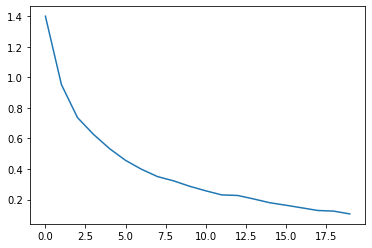

In [28]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

datapath = r"corpus.txt"

embed_dim = 400
hid_size = 600
seq_tensor, seq_lengths, vocab = build_training_batch(datapath)
seq_tensor = seq_tensor.to(device)

lstm = LSTMcomposer(in_size=embed_dim, hidden_size=hid_size, out_size=len(vocab), n_stack=1, vocab=vocab, embed_dim=embed_dim)
lstm.to(device)

trainItersLSTM(lstm, seq_tensor, seq_lengths, n_iter=100, print_every=2, plot_every=5, save_every=2, lr=0.01)